In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from HydrographTools import *
import pdb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Read in GPS Storage Volume
Read in Dude Man's duderonomy.  The fractional year right now is roughly approximate.  I'm not concerned since these are monthly values, but it could become an issue if we start looking at daily, as that nasty old leap will enter the picture...


In [2]:
duderonomy = 'russiaX.infer2'
duderonomy2 = 'russiaX.5w2'
duderonomy3 = 'russiaX.5w2.zero'
dfRR = pd.read_csv(duderonomy,names=['fYear','V_km3','uc_km3'],usecols=[0,1,2],delim_whitespace=True)
dfRR2 = pd.read_csv(duderonomy2,names=['fYear','V_km3','uc_km3'],usecols=[0,1,2],delim_whitespace=True)
dfRR3 = pd.read_csv(duderonomy3,names=['fYear','V_km3','uc_km3'],usecols=[0,1,2],delim_whitespace=True)
tOrigin=dt.datetime(1,1,1)
Date = []
dfRR['V_km3_5w2'] = dfRR2['V_km3']
dfRR['V_km3_5w2_zero'] = dfRR3['V_km3']
for i in range(len(dfRR.fYear)):
    iYear = int(dfRR.fYear[i])
    days=dt.timedelta(days=(dfRR.fYear[i]-iYear)*365)
    day1=dt.datetime(iYear,1,1)
    Date.append(day1+days)

dfRR['DateTime']=pd.to_datetime(Date)
dfRR['Date']=pd.to_datetime(Date).date
dfRR.set_index('Date',inplace=True)
dfRR.set_index(pd.to_datetime(dfRR.index),inplace=True)
dfRR.head(3)

,fYear,V_km3,uc_km3,V_km3_5w2,V_km3_5w2_zero,DateTime
Date,,,,,,
2006-01-16,2006.042,1.752,0.172,2.316,2.181,2006-01-16 07:55:11.999997
2006-02-15,2006.125,1.032,0.172,2.068,1.929,2006-02-15 15:00:00.000000
2006-03-17,2006.208,0.842,0.170,2.034,1.846,2006-03-17 22:04:48.000003


Jan 2014 is supposedly zero, so I'm going to check that here.  All changes are relative to this date per convo. with Donald et al.

               fYear  V_km3  uc_km3  V_km3_5w2  V_km3_5w2_zero  \
Date                                                             
2014-01-16  2014.042    0.0   0.137        0.0             0.0   

                             DateTime  
Date                                   
2014-01-16 2014-01-16 07:55:11.999997  


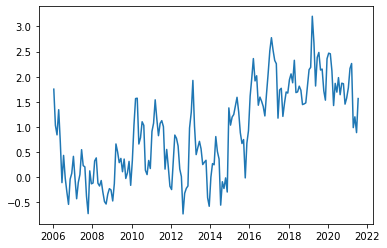

In [3]:
#going to make sure zero is zero
plt.plot(dfRR.index,dfRR.V_km3)
df_origin=dfRR[(dfRR.index.year==2014)&(dfRR.index.month==1)]
print(df_origin)

### USGS Gauges
11461000 is Russian R NR Ukiah, pretty sure this one has the Eel diversion in it.\\

11461500 is EF Russian NR Calpella, this is above Lake Medacino\\

11462500 is Russian NR Hopland - post reservoir\\

11463000 RUSSIAN R NR CLOVERDALE CA - \\

11465350 DRY C NR MOUTH NR HEALDSBURG CA - trib to Russian\\

11467000 RUSSIAN R A HACIENDA BRIDGE NR GUERNEVILLE CA - lower Russian\\

I'll start off with looking at the the full Russian to get the best apples to apples comparison. But any can analyzed by changing the site number below.  

I'll make one concatentated data frame for direct analysis.

In [4]:
#import ulmo
#siteno = 11461500
siteno = 11467000
print('reading data')
dfEFR,siteinfoEFR = ImportUsgsSiteDailyValues(siteno)
dfEFR.rename(columns={'value':'cfs'},inplace=True)
dfEFR['Disch']=dfEFR.cfs*86400*0.0003048**3 #daily discharge volume in km^3
dfEFR.head(3)
#dfEFR_concat = pd.concat([dfEFR,dfRR],axis=1,join='inner')
#dfEFR_concat.head(3)

reading data


processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=11467000&startDT=1851-01-01


,cfs,qualifiers,datetime,Disch
dates,,,,
1939-10-01,185.0,A e,1939-10-01T00:00:00,0.000453
1939-10-02,185.0,A e,1939-10-02T00:00:00,0.000453
1939-10-03,185.0,A e,1939-10-03T00:00:00,0.000453


### A first look at the raw data
An inital look at storage and dicharge.  This plot is monthly storage and daily flow over the time period we have GPS.

(13164.0, 18825.0)

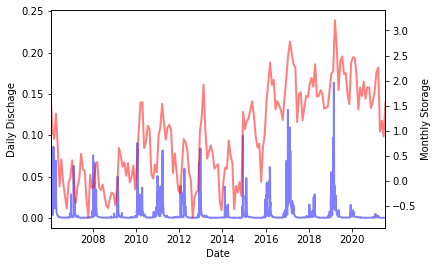

In [5]:
fig1,ax1 = plt.subplots()
ax1.plot(dfEFR.index,dfEFR.Disch,'b-',lw=2,alpha=0.5,label='Discharge')
ax2 = ax1.twinx()
ax2.plot(dfRR.index,dfRR.V_km3,'r-',lw=2,alpha=0.5,label='GPS Storage')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Dischage')
ax2.set_ylabel('Monthly Storage')
ax2.set_xlim(dfRR.index.min(),dfRR.index.max())

### Monthly accumulated discharge and GPS storage
Trying to get GPS, Discharge and precip in the same unit.  First, we convert daily average discharge to accumulated discharge volume in km3.  This is now the total volume of water removed over that month. 

Monthly total discharge volume $Q_v$ in $km^3$ is calculated as:
* $$\bar{Q}(km^3/d) = \bar{Q}(ft^3/s)*86400s/d*(1ft/0.0003048km)^3$$
* $$Q_v (km^3) = \sum_0^{dpm} \bar{Q}(km^3/d) * 1 d$$

where, $\bar{Q}$ is the average daily discharge reported by the USGS, and $dpm$ is the days per month.  

Need to change Storage to km$^3$/month too.  Do that by subracting the the months from each other.

In [6]:

#MQV=dfEFR.resample('6M').sum()
#MQV=dfEFR.groupby(pd.Grouper(freq='Q-Oct')).sum()
MQV=dfEFR.groupby(pd.Grouper(freq='M')).sum()
MQV=MQV.reindex(dfRR.index,method='bfill')
MQV_concat = pd.concat([MQV,dfRR],axis=1,join='inner')
MQV_concat['dSdt']=np.zeros(len(dfRR))
for i in range(1,len(dfRR)):
    MQV_concat['dSdt'][i]=MQV_concat['V_km3'][i]-MQV_concat['V_km3'][i-1]
MQV_concat.head(3)


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cfs,Disch,fYear,V_km3,uc_km3,V_km3_5w2,V_km3_5w2_zero,DateTime,dSdt
Date,,,,,,,,,
2006-01-16,440770.0,1.078377,2006.042,1.752,0.172,2.316,2.181,2006-01-16 07:55:11.999997,0.00
2006-02-15,127160.0,0.311107,2006.125,1.032,0.172,2.068,1.929,2006-02-15 15:00:00.000000,-0.72
2006-03-17,375190.0,0.917931,2006.208,0.842,0.170,2.034,1.846,2006-03-17 22:04:48.000003,-0.19


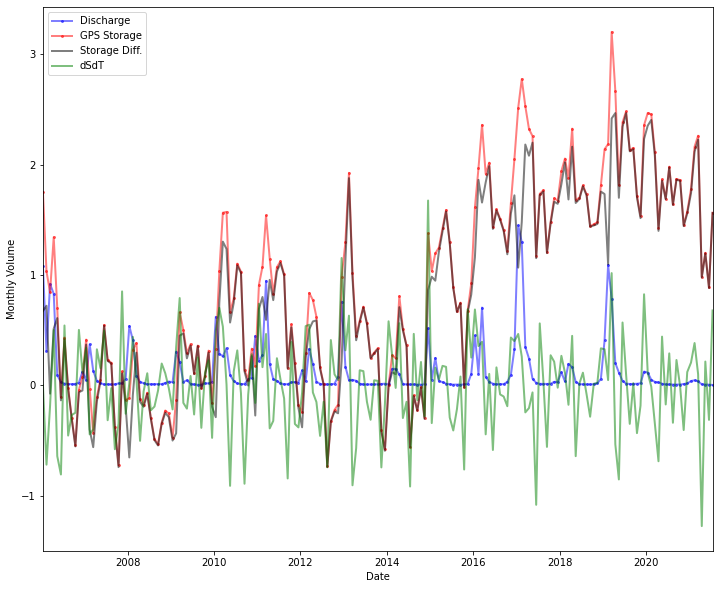

In [7]:
fig2,ax3 = plt.subplots(figsize=(12,10))
line1 = ax3.plot(MQV.index,MQV.Disch,'bo-',lw=2,ms=2,alpha=0.5,label='Discharge')
#ax4 = ax3.twinx()
line2 = ax3.plot(dfRR.index,dfRR.V_km3,'ro-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
line3 = ax3.plot(MQV_concat.index,MQV_concat.V_km3-MQV_concat.Disch,'k',lw=2,alpha=.5,label='Storage Diff.')
line4 = ax3.plot(MQV_concat.index,MQV_concat.dSdt,'g',lw=2,alpha=0.5,label='dSdT')
ax3.set_xlabel('Date')
ax3.set_ylabel('Monthly Volume')
#ax3.set_ylabel('Monthly Storage Balance')
ax3.set_xlim(dfRR.index.min(),dfRR.index.max())
ax3.legend()

Coefficient of determination: 0.09


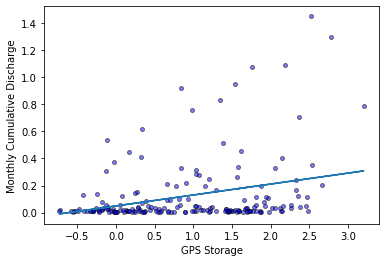

In [8]:
fig3,ax4 = plt.subplots()
MQVri = MQV.reindex(dfRR.index,method='bfill')
ax4.plot(MQV_concat.V_km3,MQV_concat.Disch,'bo',ms=4,mec='k',alpha=0.5)
ax4.set_xlabel('GPS Storage')
ax4.set_ylabel('Monthly Cumulative Discharge')
reg = LinearRegression().fit(MQV_concat.V_km3.values.reshape(-1,1),MQV_concat.Disch)
reg.score(MQV_concat.V_km3.values.reshape(-1,1),MQV_concat.Disch)
disch_pred = reg.predict(MQV_concat.V_km3.values.reshape(-1,1))
ax4.plot(MQV_concat.V_km3,disch_pred)
# The coefficients
#print("Coefficients: \n", reg.coef_)
# The mean squared error
#print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(MQVri.Disch, disch_pred))

The two signals look visually to have better coherence now, but the linear correlation sucks.  
### Flow and Flow Anomaly with different time periods
First I think it would be useful to look at the correlation for different accumulation time periods.  

Here I first accumulate flow for a given time period using a rolling window.  The value is the sum of the previous window length days. Then a groupby dayofyear gives the accumulated flow grouped by each calendar day. Can then calculate an empircal cdf or ranking anomaly.  It interesting to play with the window length and see if there are differences.  

30D Flow Window


(13164.0, 18825.0)

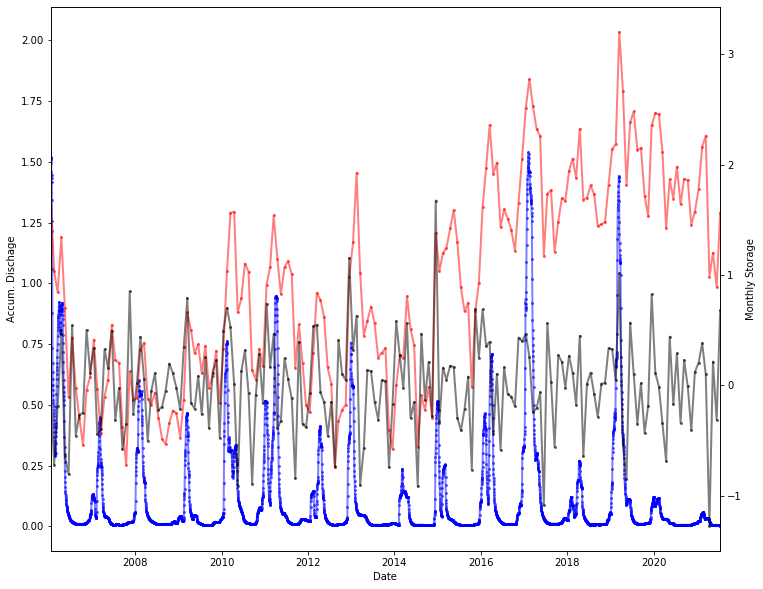

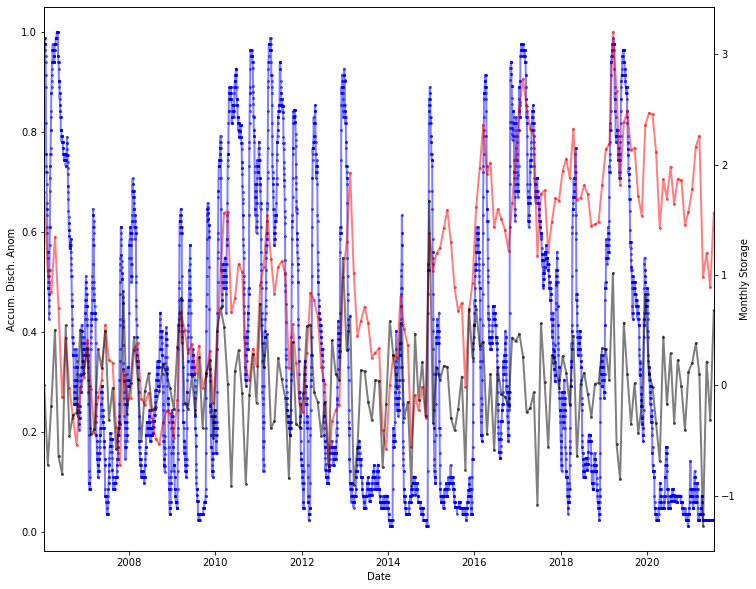

In [9]:
#length of window in days
daywin=30
daystring='%1iD '%daywin
print(daystring +'Flow Window')
#MQVe=dfEFR.rolling(window='7D',min_periods=7).sum()
#MQVe=dfEFR.rolling(window='7D',).sum().groupby(dfEFR.index.dayofyear).mean()
#MQVe_av=dfEFR.rolling(window='7D',min_periods=7).sum().groupby(dfEFR.index.dayofyear).mean()
MQVe=dfEFR.rolling(window=daystring,min_periods=daywin).sum()
MQVe_anom=dfEFR.rolling(window=daystring,min_periods=daywin).sum().groupby(dfEFR.index.dayofyear).rank(pct=True)
MQVe_av=dfEFR.groupby(dfEFR.index.dayofyear).mean()
MQVe_av_anom=dfEFR.rolling(window=daystring,min_periods=daywin).sum().groupby(dfEFR.index.dayofyear).mean()

fig3,ax5 = plt.subplots(figsize=(12,10))
ax5.plot(MQVe.index,MQVe.Disch,'bo-',lw=2,ms=2,alpha=0.5,label='Accum. Discharge')
ax6 = ax5.twinx()
ax6.plot(dfRR.index,dfRR.V_km3,'ro-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
ax6.plot(MQV_concat.index,MQV_concat.dSdt,'ko-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
ax5.set_xlabel('Date')
ax5.set_ylabel('Accum. Dischage')
ax6.set_ylabel('Monthly Storage')
ax5.set_xlim(dfRR.index.min(),dfRR.index.max())

fig4,ax7 = plt.subplots(figsize=(12,10))
ax7.plot(MQVe_anom.index,MQVe_anom.Disch,'bo-',lw=2,ms=2,alpha=0.5,label='Accum. Disch. Anom.')
ax8 = ax7.twinx()
ax8.plot(dfRR.index,dfRR.V_km3,'ro-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
ax8.plot(MQV_concat.index,MQV_concat.dSdt,'ko-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
ax7.set_xlabel('Date')
ax7.set_ylabel('Accum. Disch. Anom')
ax8.set_ylabel('Monthly Storage')
ax7.set_xlim(dfRR.index.min(),dfRR.index.max())

### GPS vs Flow Anomal
I would like to calculate anomaly for GPS and then compare anomaly.  After some though, I think it only makes sense to compare monthly discharge.  So I'm only going to use the monthly cumulative discharge.  Not sure whether to use full time series or GPS time series for flow anomaly.  Going to start with full time series...

0.05279648073691512
Coefficients: 
 [0.2351205] 
 Intercept: 
 0.23625709647656654
Coefficient of determination: 0.05


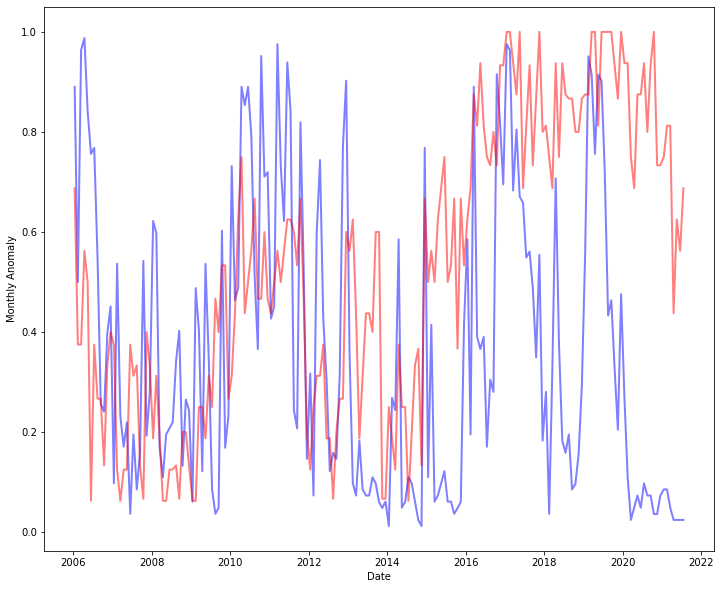

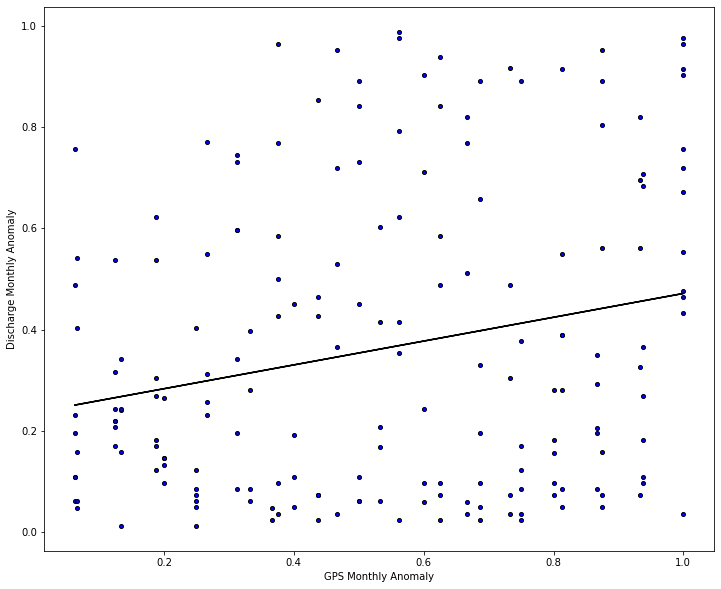

In [10]:
MQV=dfEFR.groupby(pd.Grouper(freq='1M')).sum()
MQVri = MQV.reindex(dfRR.index,method='bfill')
MQV_anom = MQV.groupby(MQV.index.month).rank(pct=True)
dfRR_anom = dfRR.groupby(dfRR.index.month).rank(pct=True)

fig5,ax9 = plt.subplots(figsize=(12,10))
MQV_anom_ri = MQV_anom.reindex(dfRR_anom.index,method='bfill')
ax9.plot(MQV_anom_ri.index,MQV_anom_ri.Disch,'b-',lw=2,alpha=0.5)
ax9.plot(dfRR_anom.index,dfRR_anom.V_km3,'r-',lw=2,alpha=0.5)
ax9.set_xlabel('Date')
ax9.set_ylabel('Monthly Anomaly')
reg = LinearRegression(fit_intercept=True).fit(dfRR_anom.V_km3.values.reshape(-1,1),MQV_anom_ri.Disch)
print(reg.score(dfRR_anom.V_km3.values.reshape(-1,1),MQV_anom_ri.Disch))
disch_pred = reg.predict(dfRR_anom.V_km3.values.reshape(-1,1))
fig6,ax10 = plt.subplots(figsize=(12,10))
ax10.plot(dfRR_anom.V_km3,MQV_anom_ri.Disch,'bo',ms=4,mec='k')
ax10.plot(dfRR_anom.V_km3,disch_pred,'k')
ax10.set_ylabel('Discharge Monthly Anomaly')
ax10.set_xlabel('GPS Monthly Anomaly')
# The coefficients
print("Coefficients: \n", reg.coef_, "\n Intercept: \n", reg.intercept_)
# The mean squared error
#print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" %r2_score(MQV_anom_ri.Disch,disch_pred))

### Precipitation
I'd like to add in precipitation.  Precip from grid met - summed over the basin for all pixels.  From Hoylman.

In [11]:
p_file = 'russian_precip_sum_mm_232px.csv'
df_RRP = pd.read_csv(p_file,parse_dates=True)
df_RRP.head(3)
df_RRP['Date']=pd.to_datetime(df_RRP.time)
df_RRP.set_index('Date',inplace=True)
df_RRP.drop(columns='time',inplace=True)
df_RRP['PV']=df_RRP['sum']/1e6*4**2 #should be km^3
MPV=df_RRP.groupby(pd.Grouper(freq='1M')).sum()
MPV.head(3)

,sum,PV
Date,,
1979-01-31,65442.400006,1.047078
1979-02-28,69545.300040,1.112725
1979-03-31,27161.299995,0.434581


First lets just have a look at all of these and see how they line up.

(13164.0, 18825.0)

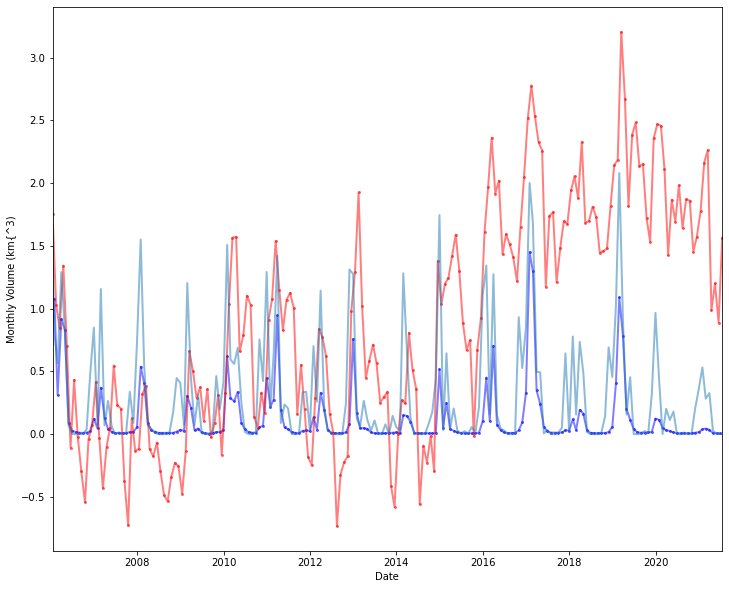

In [12]:
fig7,ax11 = plt.subplots(figsize=(12,10))
line1 = ax11.plot(MQV.index,MQV.Disch,'bo-',lw=2,ms=2,alpha=0.5,label='Discharge')
#ax4 = ax3.twinx()
line2 = ax11.plot(dfRR.index,dfRR.V_km3,'ro-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
#line3 = ax3.plot(MQV_concat.index,MQV_concat.V_km3-MQV_concat.Disch,'k',lw=2,alpha=.5,label='Storage Diff.')
#line4 = ax3.plot(MQV_concat.index,MQV_concat.V_km3+MQV_concat.Disch,'g',lw=2,alpha=0.5,label='P-ET')
line3 = ax11.plot(MPV.index,MPV.PV,color='tab:blue',lw=2,alpha=0.5,label='Precip')
ax11.set_xlabel('Date')
ax11.set_ylabel('Monthly Volume (km{^3)')
#ax3.set_ylabel('Monthly Storage Balance')
ax11.set_xlim(dfRR.index.min(),dfRR.index.max())

Just want to look at Rolling Mean dischage and Precipitation. It really would be better to be able to adjust the daywin here, and then rolling sum both Precip and Discharge.  In this cell, but for now will work with this.

(13164.0, 18825.0)

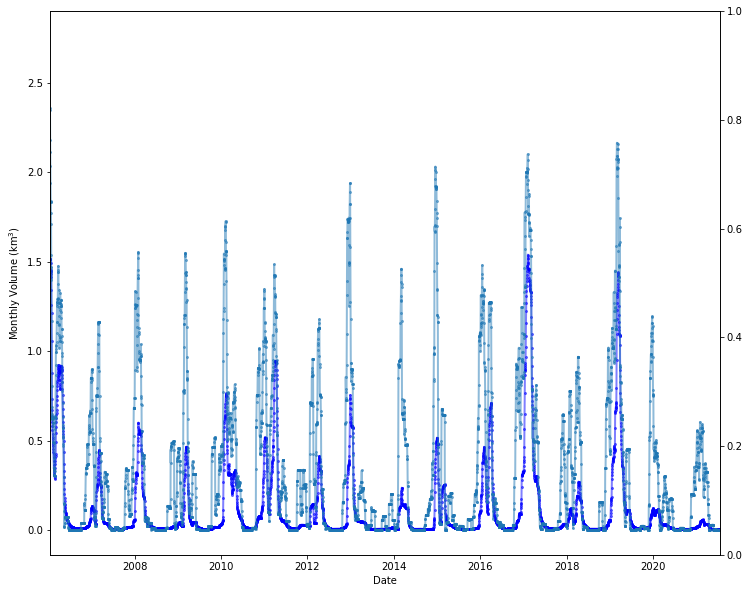

In [13]:
RRP_rolling = df_RRP.rolling(window=daystring,min_periods=daywin).sum()
fig7,ax11 = plt.subplots(figsize=(12,10))
line1 = ax11.plot(MQVe.index,MQVe.Disch,'bo-',lw=2,ms=2,alpha=0.5,label='Discharge')
ax12 = ax11.twinx()
#line2 = ax11.plot(RRP_rolling.index,RRP_rolling.PV,'ro-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
#line3 = ax3.plot(MQV_concat.index,MQV_concat.V_km3-MQV_concat.Disch,'k',lw=2,alpha=.5,label='Storage Diff.')
#line4 = ax3.plot(MQV_concat.index,MQV_concat.V_km3+MQV_concat.Disch,'g',lw=2,alpha=0.5,label='P-ET')
line3 = ax11.plot(RRP_rolling.index,RRP_rolling.PV,'o-',color='tab:blue',lw=2,alpha=0.5,label='Precip',ms=2)
ax11.set_xlabel('Date')
ax11.set_ylabel(r'Monthly Volume (km${^3}$)')

#ax3.set_ylabel('Monthly Storage Balance')
ax11.set_xlim(dfRR.index.min(),dfRR.index.max())

I want to look at psuedo storage, and the accumulated pseudo storage over time.  Pseudo storage is a proxy for basin storage and is given by:  $$\hat{S}=\bar{P}-\bar{Q}$$ where $\bar{P}$ and $\bar{Q}$ are the rolling accumulated precip and discharge over the window.  The accunulated Pseudo is rolling and basically is the time integrated change over a given window. I think this would be the rolling precipitation excess in volume, with no implicit time unit.

In [14]:
from scipy import integrate
MQVpri=MQVe.reindex(RRP_rolling.index,method='nearest')
MQVe.index
MQVe_concat = pd.concat([RRP_rolling,MQVpri],axis=1)
MQVe_concat.dropna(inplace=True)
#MQVe_concat.head(35)

MQVe_concat['PseudoSt']=MQVe_concat.PV-MQVe_concat.Disch
#MQVe_concat['IntStor']=MQVe_concat.PseudoSt.rolling(window='450D').apply(integrate.trapz)
MQVe_concat['IntStor']=MQVe_concat.PseudoSt.rolling(window='500D').sum()

(13164.0, 18825.0)

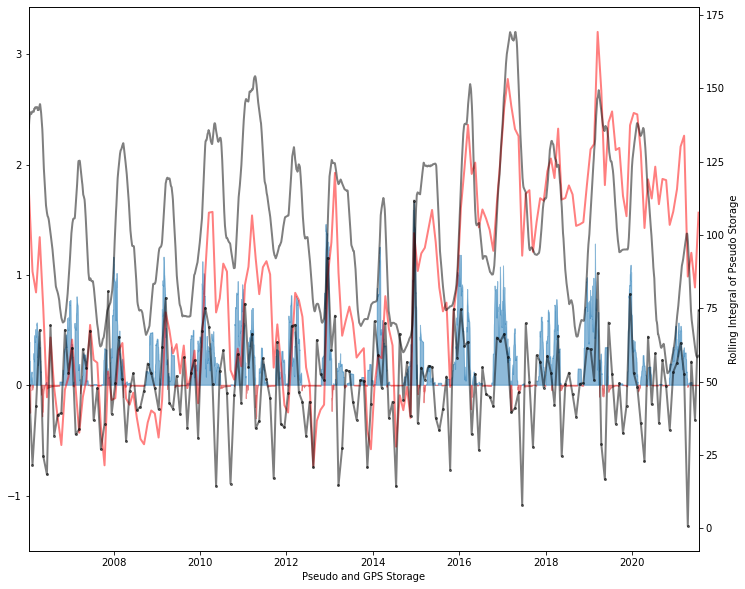

In [17]:
fig12,ax15 = plt.subplots(figsize=(12,10))
ax15.fill_between(MQVe_concat.index,0,MQVe_concat.PseudoSt,color='tab:blue',alpha=0.5, where=MQVe_concat.PseudoSt>0)
ax15.fill_between(MQVe_concat.index,0,MQVe_concat.PseudoSt,color='tab:red',alpha=0.5, where=MQVe_concat.PseudoSt<0)
ax15.plot(dfRR.index,dfRR.V_km3,'r-',lw=2,alpha=0.5)
#MQVe_concat.PseudoSt.rolling(window='180D').apply(integrate.trapz)
ax16=ax15.twinx()
ax15.set_xlabel("Pseudo and GPS Storage")
ax16.set_ylabel("Rolling Integral of Pseudo Storage")
ax16.plot(MQVe_concat.index,MQVe_concat.IntStor,'k-',lw=2,alpha=0.5)
ax15.plot(MQV_concat.index,MQV_concat.dSdt,'ko-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
ax15.set_xlim(dfRR.index.min(),dfRR.index.max())

I'd like to look at the correlation of Pseudo Storage and GPS storage for a given time length.  Will reindex GPS to daily using linear interpolation.  Might be sketchy...

In [18]:
dfRR_ri = dfRR.resample('D').mean()
dfRR_ri.V_km3.interpolate(method='time',inplace=True)
MQVe_concat2=pd.concat([MQVe_concat,dfRR_ri.V_km3],join='inner',axis=1)
dfRR_ri.head(3)
#dfRR_ri=dfRR_ri.interpolate(method='time',limit_area='inside')
#dfRR_ri[dfRR_ri.V_km3>0]
#dfRR.index
#dfRR_int[dfRR_int.V_km3>0]
MQVe_concat2.head(3)

,sum,PV,cfs,Disch,PseudoSt,IntStor,V_km3
Date,,,,,,,
2006-01-16,146647.299947,2.346357,616850.0,1.509170,0.837187,137.416238,1.752
2006-01-17,136253.799938,2.180061,620440.0,1.517953,0.662107,138.086251,1.728
2006-01-18,132114.899928,2.113838,619640.0,1.515996,0.597842,138.692047,1.704


Coefficients: 
 [14.35952437] 
 Intercept: 
 89.07890873931274
Coefficient of determination: 0.24


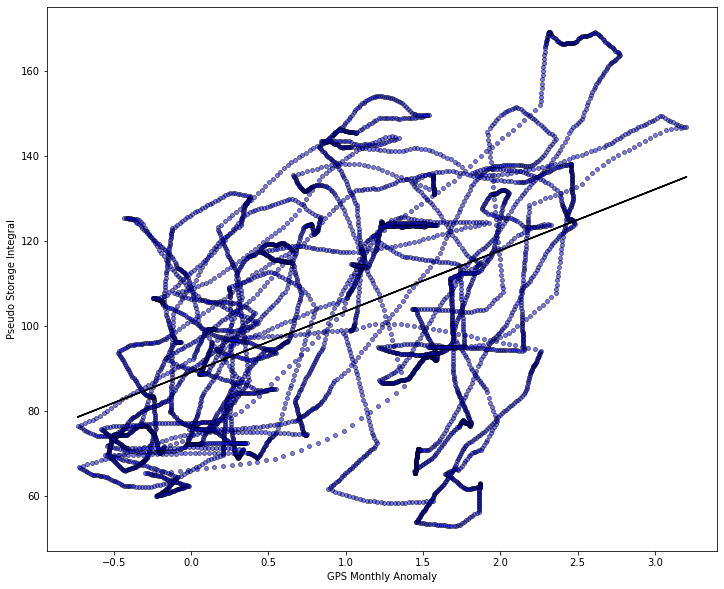

In [19]:
#dfRR_ri = dfRR.reindex(MQVe_concat.index,method=None)
#dfRR_ri.interpolate(method='time',limit_area='inside',inplace=True)
#dfRR_ri.head(3)
reg = LinearRegression(fit_intercept=True).fit(MQVe_concat2.V_km3.values.reshape(-1,1),MQVe_concat2.IntStor)
#print(reg.score(dfRR_anom.V_km3.values.reshape(-1,1),MQV_anom_ri.Disch))
disch_pred = reg.predict(MQVe_concat2.V_km3.values.reshape(-1,1))
fig6,ax10 = plt.subplots(figsize=(12,10))
ax10.plot(MQVe_concat2.V_km3,MQVe_concat2.IntStor,'bo',ms=4,mec='k',alpha=0.5)
ax10.plot(MQVe_concat2.V_km3,disch_pred,'k')
ax10.set_ylabel('Pseudo Storage Integral')
ax10.set_xlabel('GPS Monthly Anomaly')
# The coefficients
print("Coefficients: \n", reg.coef_, "\n Intercept: \n", reg.intercept_)
# The mean squared error
#print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" %r2_score(MQVe_concat2.IntStor,disch_pred))

From my quick and dirty analysis, 500 days is giving the best match.  Still not great.  And the linear interpolation is obvious.  Also, this is a bit of wierd analysis, as I have first done a rolling 30 day cumulative for P and ET, and then done a rolling accumulated P-Q for 

Now calculate ET from the watershed mass balance equation:  $$ET=P-Q-\Delta S$$

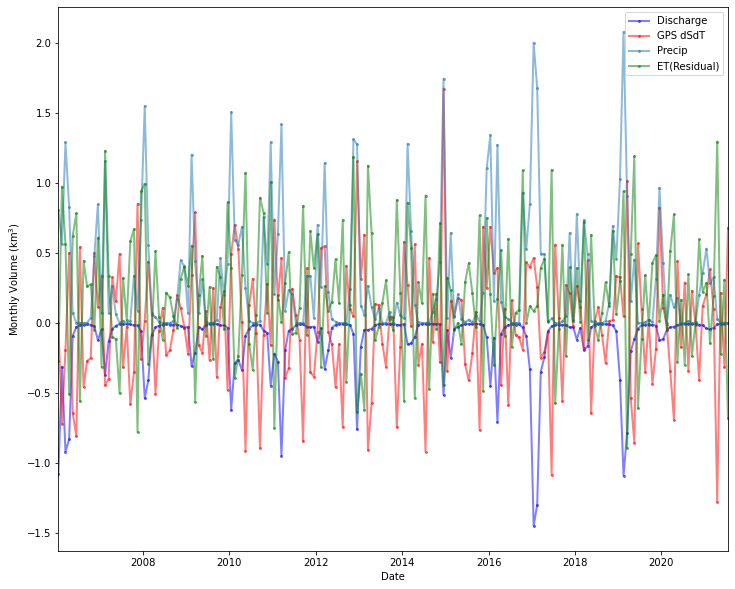

In [24]:
MPVri = MPV.reindex(dfRR.index,method='bfill')
MV_concat = pd.concat([MQV_concat,MPVri],axis=1,join='inner')
MV_concat['ET']=MV_concat.PV-MV_concat.Disch-MV_concat.dSdt
fig8,ax12 = plt.subplots(figsize=(12,10))
#ax13 = ax12.twinx()
line1 = ax12.plot(MV_concat.index,-1*MV_concat.Disch,'bo-',lw=2,ms=2,alpha=0.5,label='Discharge')
#line2 = ax12.plot(MV_concat.index,MV_concat.V_km3,'ro-',ms=2,lw=2,alpha=0.3,label='Infer')
#line2 = ax12.plot(MV_concat.index,MV_concat.V_km3_5w2,'ro-',ms=2,lw=2,alpha=0.6,label='5w2')
#line2 = ax12.plot(MV_concat.index,MV_concat.V_km3_5w2_zero,'ro-',ms=2,lw=2,alpha=1,label='5w2_zero')
ax12.plot(MQV_concat.index,MQV_concat.dSdt,'ro-',ms=2,lw=2,alpha=0.5,label='GPS dSdT')
#line3 = ax3.plot(MQV_concat.index,MQV_concat.V_km3-MQV_concat.Disch,'k',lw=2,alpha=.5,label='Storage Diff.')
#line4 = ax3.plot(MQV_concat.index,MQV_concat.V_km3+MQV_concat.Disch,'g',lw=2,alpha=0.5,label='P-ET')
line3 = ax12.plot(MV_concat.index,MV_concat.PV,'o-',color='tab:blue',lw=2,alpha=0.5,label='Precip',ms=2)
line3 = ax12.plot(MV_concat.index,MV_concat.ET,'o-',color='g',lw=2,alpha=0.5,label='ET(Residual)',ms=2)
ax12.set_xlabel('Date')
ax12.set_ylabel(r'Monthly Volume (km${^3}$)')
#ax3.set_ylabel('Monthly Storage Balance')
#ax12.plot(MV_concat.index,MV_concat.PV-MV_concat.Disch,'ko-',lw=2,alpha=0.5,ms=2,label='PseudoStorage')
ax12.set_xlim(dfRR.index.min(),dfRR.index.max())
ax12.legend()
#ax12.set_ylim(-.25,.25)

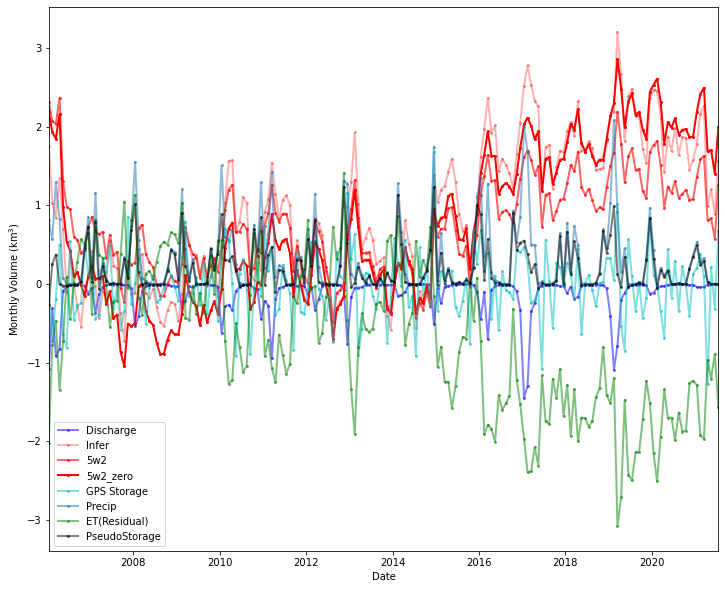

In [22]:
MPVri = MPV.reindex(dfRR.index,method='bfill')
MV_concat = pd.concat([MQV_concat,MPVri],axis=1,join='inner')
MV_concat['ET']=MV_concat.PV-MV_concat.Disch-MV_concat.V_km3
fig8,ax12 = plt.subplots(figsize=(12,10))
#ax13 = ax12.twinx()
line1 = ax12.plot(MV_concat.index,-1*MV_concat.Disch,'bo-',lw=2,ms=2,alpha=0.5,label='Discharge')
line2 = ax12.plot(MV_concat.index,MV_concat.V_km3,'ro-',ms=2,lw=2,alpha=0.3,label='Infer')
line2 = ax12.plot(MV_concat.index,MV_concat.V_km3_5w2,'ro-',ms=2,lw=2,alpha=0.6,label='5w2')
line2 = ax12.plot(MV_concat.index,MV_concat.V_km3_5w2_zero,'ro-',ms=2,lw=2,alpha=1,label='5w2_zero')
ax12.plot(MQV_concat.index,MQV_concat.dSdt,'co-',ms=2,lw=2,alpha=0.5,label='GPS Storage')
#line3 = ax3.plot(MQV_concat.index,MQV_concat.V_km3-MQV_concat.Disch,'k',lw=2,alpha=.5,label='Storage Diff.')
#line4 = ax3.plot(MQV_concat.index,MQV_concat.V_km3+MQV_concat.Disch,'g',lw=2,alpha=0.5,label='P-ET')
line3 = ax12.plot(MV_concat.index,MV_concat.PV,'o-',color='tab:blue',lw=2,alpha=0.5,label='Precip',ms=2)
line3 = ax12.plot(MV_concat.index,MV_concat.ET,'o-',color='g',lw=2,alpha=0.5,label='ET(Residual)',ms=2)
ax12.set_xlabel('Date')
ax12.set_ylabel(r'Monthly Volume (km${^3}$)')
#ax3.set_ylabel('Monthly Storage Balance')
ax12.plot(MV_concat.index,MV_concat.PV-MV_concat.Disch,'ko-',lw=2,alpha=0.5,ms=2,label='PseudoStorage')
ax12.set_xlim(dfRR.index.min(),dfRR.index.max())
ax12.legend()
#ax12.set_ylim(-.25,.25)

Export for Donald.

In [ ]:
fig8.savefig('RussianBudgetPlot.png',dpi=200)
MV_export=MV_concat.drop(columns=['cfs','fYear','sum','DateTime','uc_km3','ET'])
MV_export.rename(columns={'Disch':'Q_km3','V_km3':'dS_km3','PV':'P_km3'},inplace=True)
MV_export.head(3)
MV_export.to_csv('RussianMonthlyBudgetTerms.csv')

The monthly storage is change relative to Jan 2014, so basically negative ET here is somehow relative to Jan 2014.  I have a couple thoughts about the large positive excursion of the GPS and the negative excursion of ET. 
- My first observation is that the P-Q pseudo-storage is small fry compared to the GPS storage.  Basically ET is the residual between GPS-Storage and P-Q, and its basically the inverse of GPS storage.  
- The GPS storage shows coherency to many of the precipitation events, but we see large offsets when P and Q are flat
- The large positive excursion starting in 2015 of GPS Storage is not well correlated to changes in cumulative precipitation at the monthly level at least.  
- I wonder if a lot of this is "leakage" from other basins.

TO DO - Probably worth doing this analysis and acummulating over different time spans. 

### SPI
Now let's look into SPI and see if the SPI and the storage have any good trends.

In [ ]:
spi_file = 'russian-spi-summary.csv'
df_RRSPI = pd.read_csv(spi_file)
df_RRSPI['Date']=pd.to_datetime(df_RRSPI.time)
df_RRSPI.set_index('Date',inplace=True)
df_RRSPI.drop(columns='time',inplace=True)
df_RRSPI.head(3)

In [ ]:
t_str = 't_30'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(dfRR.index,dfRR.V_km3,'ko-',ms=2,alpha=0.5,lw=2)
ax13.set_xlabel('Date')
ax14.set_ylabel('GPS Monthly Volume')
ax13.set_ylabel(t_str+' Day SPI')

Not a ton of coherence, but there are definitely areas of coherence.  Now lets try looking at different time periods.

In [ ]:
t_str = 't_60'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(dfRR.index,dfRR.V_km3,'ko-',ms=2,alpha=0.5,lw=2)
ax13.set_xlabel('Date')
ax14.set_ylabel('GPS Monthly Volume')
ax13.set_ylabel(t_str+' Day SPI')

In [ ]:
t_str = 't_180'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(dfRR.index,dfRR.V_km3,'ko-',ms=2,alpha=0.5,lw=2)
ax13.set_xlabel('Date')
ax14.set_ylabel('GPS Monthly Volume')
ax13.set_ylabel(t_str+' Day SPI')

In [ ]:
t_str = 't_365'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(dfRR.index,dfRR.V_km3,'ko-',ms=2,alpha=0.5,lw=2)
ax13.set_xlabel('Date')
ax14.set_ylabel('GPS Monthly Volume')
ax13.set_ylabel(t_str+' Day SPI')

In [ ]:
t_str = 't_720'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(dfRR.index,dfRR.V_km3,'ko-',ms=2,alpha=0.5,lw=2)
ax13.set_xlabel('Date')
ax14.set_ylabel('GPS Monthly Volume')
ax13.set_ylabel(t_str+' Day SPI')

So there are periods of coherence for all the different time periods.  This ends up looking fairly decent.  Maybe an SPI type approach for flow would yield better coherence between GPS storage and discharge.  

### SPI and Flow
I want to look at SPI and flow.  Are they correlated/show coherence at all?

In [ ]:
t_str = 't_30'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(MQVe.index,MQVe.Disch,'ko-',ms=2,alpha=0.5,lw=2) #monthly rolling accumulated flow
ax13.set_xlabel('Date')
ax14.set_ylabel('Discharge 30 Day Anomaly')
ax13.set_ylabel(t_str+' Day SPI')
ax13.set_xlim(dfRR.index.min(),dfRR.index.max())

### SPI and Flow Anomaly
I want to look at SPI and flow anomaly. Are they correlated/show coherence at all?

In [ ]:
t_str = 't_60'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(MQVe_anom.index,MQVe_anom.Disch,'k-',ms=2,alpha=0.5,lw=2) #monthly rolling accumulated flow
ax13.set_xlabel('Date')
ax14.set_ylabel('Discharge 30 Day Anomaly')
ax13.set_ylabel(t_str+' Day SPI')
ax13.set_xlim(dfRR.index.min(),dfRR.index.max())

### SPI and GPS Anomaly
I want to look at SPI and GPS anomaly. Are they correlated/show coherence at all?  Should look at different time lengths of accumulation.



In [ ]:
t_str = 't_365'
fig9,ax13 = plt.subplots(figsize=(12,10))
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]>0, interpolate=True, color='b', alpha=0.5)
ax13.fill_between(df_RRSPI.index,0,df_RRSPI[t_str],where=df_RRSPI[t_str]<0, interpolate=True, color='r', alpha=0.5)
ax14=ax13.twinx()
ax14.plot(dfRR_anom.index,dfRR_anom.V_km3,'ko-',ms=2,alpha=0.5,lw=2)
ax13.set_xlabel('Date')
ax14.set_ylabel('GPS Monthly Anomaly')
ax13.set_ylabel(t_str+' Day SPI')

### Thoughts SO FAR
Next steps
1. Should consider treats anomalies for GPS and flow exactly like SPI, so there's a closer apples to apples comparison
2. Should perform regression analysis for all the different time scales of accumulation